In [1]:
from gym import Env # placeholder class that allows us to build our custom environment
from gym.spaces import Discrete, Box
#define actions, current state
import numpy as np
import random
import pandas as pd

In [3]:
Solar = pd.read_csv('Solar_Generation_Data.csv')
PowerConsumption = pd.read_csv('Power_Consumption_Data.csv')
GridPrice = pd.read_csv('costData.csv')

In [4]:
GridPrice = GridPrice.loc[::6,].dropna().reset_index(drop=True)

In [5]:
Solar = Solar['Generation (kW)'].tolist()
PowerConsumption = PowerConsumption['Consumption (kW)'].tolist()
SummerGridPrice = GridPrice["summer"].to_list()

In [6]:
type(Solar)

list

In [7]:
print("Solar:", Solar)
print("PowerConsumption:", PowerConsumption)
print("SummerGridPrice:", SummerGridPrice)

Solar: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.02, 0.04, 0.11, 0.25, 0.56, 1.14, 2.2, 3.98, 6.77, 10.81, 16.23, 22.89, 30.33, 37.74, 44.12, 48.46, 50.0, 48.46, 44.12, 37.74, 30.33, 22.89, 16.23, 10.81, 6.77, 3.98, 2.2, 1.14, 0.56, 0.25, 0.11, 0.04, 0.02, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
PowerConsumption: [0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.03, 0.15, 0.55, 1.64, 4.04, 8.13, 13.41, 18.1, 20.0, 18.1, 13.41, 8.13, 4.04, 1.64, 0.55, 0.15, 0.03, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.05, 0.22, 0.82, 2.46, 6.06, 12.2, 20.11, 27.15, 30.0, 27.15, 20.11, 12.2, 6.06, 2.46, 0.82, 0.22, 0.05, 0.01]
SummerGridPrice: [76.5, 76.5, 76.5, 76.5, 76.5, 76.5, 76.5, 76.5, 76.5, 76.5, 76.5, 76.5, 76.5, 76.5, 76.5, 76.5, 121.2, 121.2, 121.2, 121.2, 121.2, 121.2, 187.1, 187.1, 121.2, 121.2, 187.1, 187.1, 187.1, 187.1, 187.1, 187.1, 187.1, 187.1, 187.1, 187.1, 121.2, 121.2, 121.2, 121.2, 121.2, 121.2, 121.2, 121.2, 121.2, 121.2, 121.2, 121.2]


tPV : 시점 t의 태양광 발전 전력량  
tPVuse : 시점 t의 태양광 발전 전력의 사용량. (0 <= tPVuse <= tPV)  
tESSsoc : 시점 t의 배터리 충전률  
tESSuse : 시점 t의 배터리 전력의 사용량.  (0 <= tESSuse <= tESSsoc)  
tGRIDuse : 시점 t의 그리드 전력의 사용량  
  
tLoad : 시점 t의 부하 전력량  
tLoad = tPVuse + tESSuse + tGRIDuse  
  
tSP : 시점 t의 잉여 전력량.  
tP2E : 배터리에 저장될 전력량  
tSP = tP2E = tPV - tPVuse  
  
battEnergy : 배터리 용량  
battEnergy = 2500 * 3.6e6 = 9 billion = 900 MW = 900000 kW  
Einit : 배터리 초기 충전량  
Einit = 0.5 * battEnergy  
battMinMaxE : 배터리 충전량 가능 범위  
battMinMaxE = 0.2(battEnergy) ~ 0.8(battEnergy)   
battMinMaxP : 배터리 충/방전 전력 최대치  
battMinMaxP = +-400KW  

In [8]:
Alpha = [0] * 48
Beta = [0] * 48

In [9]:
class ESSEnvA(Env):
    def __init__(self):
        """
        initialize
        the actions that we can take
        the observation space, temperature, shower length
        """

        # Actions we can take, down, stay, up
        # Load에 대한 PV, ESS, Grid의 전력 사용 비율.
        # 충전 or 방전 (때려죽어도 충방전이 동시에 일어나진 않음)
        self.action_space = Discrete(100) # 0, 1, 2
        # Temperature array => ESS 충전량
        self.observation_space = Box(low=np.array([0]), high=np.array([100]))
        # Box space gives you a lot more fle continuous value.
        """
        Box space gives you a lot more flexibility and allows you to also pass through multiple values.
        We've used a single value array but it could hold an n-dimensional tensor and could be used to hold dataframes, images and audio
        """
        # Set initiate ESS percentage
        self.state = 50

        # Set initiate Grid cost
        self.tCumulatedGridCost = 0

        # Set step length
        self.time_point = 48


        # Set weight for PV and ESS
        #self.Alpha = [0] * 48
        #self.Beta = [0] * 48

    def step(self, action):
        """
        what we do, whenever we take a step and how we treat actions
        # Apply action
        # 0 -1 = -1 Alpha decrease
        # 1 -1 = 0
        # 2 -1 = 1 Alpha increase
        """

        # Solar, PowerConsumption, SummerGridPrice

        ## 데이터와 Parameter 호출
        # 시점 t의 전력 사용량
        tLoad = PowerConsumption[48-self.time_point]

        # 시점 t의 태양광 발전량
        tPV = Solar[48-self.time_point]

        # 시점 t의 태양광 발전 전력 사용량 가중치 계수. 크면 클수록 많은 태양광 전력 사용
        tAlpha = Alpha[48-self.time_point]

        # 시점 t의 ESS 방전 계수. 크면 클수록 많은 ESS 전력 사용
        tBeta = Beta[48-self.time_point] #갱신 전의 ESS

        # 시점 t의 그리드 전력 단가
        tGridPrice = SummerGridPrice[48-self.time_point]

        # action으로 변경된 Alpha 값이 유지가 되면서 변경되어야함
        tAlpha = action * 0.01

        # Action에 따른 tAlpha 변화율이 가장 큰 항목에


        reward = 0




        # state
        """
        배터리 충전률 (%)
        """
        # action case
        """
        전력 사용
        태양광 전력 X ESS X 그리드 O
        태양광 전력 O ESS X 그리드 O
        태양광 전력 X ESS O 그리드 O
        태양광 전력 O ESS O 그리드 O

        태양광 전력 O ESS X 그리드 X
        태양광 전력 X ESS O 그리드 X
        태양광 전력 O ESS O 그리드 X

        태양광 전력 Alpha 조정
        ESS 전력 Beta 조정
        """
        # Reward case
        """
        리워드 정책
        누적 가격/100
        """



        ## 태양광 처리
        # 태양광발전량 - (태양광 발전량)*A

        # 시점 t의 태양광 발전 전력 사용량
        if tPV * tAlpha < tLoad:
            tPVuse = tPV * tAlpha
        else: tPVuse = tLoad
        # 시점 t의 태양광 발전 잉여 전력량
        tSP = tPV - tPVuse
        # 시점 t의 태양광 발전 전력 P2E, ESS 증가율
        tP2E = (tSP / 900000) * 100




        # 시점 t의 배터리 전력 사용량
        tESSuse = (tLoad - tPVuse) * tBeta
        # 시점 t의 배터리 전력 E2P, ESS 감소율
        tE2P = (tESSuse / 900000) * 100



        # 시점 t의 그리드 전력 사용량
        tGRIDuse = tLoad - tPVuse - tESSuse
        # 시점 t의 그리드 전력 누적 비용
        tGridCost = tGRIDuse * tGridPrice



        self.tCumulatedGridCost = self.tCumulatedGridCost + tGridCost


        ## ESS 처리
        # Calculate reward for [ESS]
        # tESS : SOC(%) / tESSuse : 전력량
        # 시점 t의 ESS 전력 방전
        """if (self.state - tE2P) > 20:
            self.state = self.state - tE2P
        else : reward = -1000"""

        # 시점 t의 태양광 발전 ESS 충전
        if (self.state + tP2E) < 80: # 잉여 전력을 ESS로 저장했을 때 80% 이하면 저장
            self.state = self.state + tP2E
            Alpha[48-self.time_point] = tAlpha
        else : reward = -1000; #Alpha[48-self.time_point] = tAlpha # 잉여 전력을 ESS로 저장했을 때 80% 이상이면 저장안함

        # Calculate reward for [Weight]
        reward -= (self.tCumulatedGridCost * 0.01)/self.time_point

        # Reduce time length by 1 second
        self.time_point -= 1

        # Check if shower is done
        if self.time_point <= 0:
            done = True
        else:
            done = False

        # Set placeholder for info
        info = {}

        # Return step information
        return self.state, reward, done, {"cost":self.tCumulatedGridCost}

    def render(self):
        pass

    def reset(self):
        # Reset ESS Storage
        self.state = 50
        # Reset time point
        self.time_point = 48
        # Reset total grid cost
        self.tCumulatedGridCost = 0
        # Reset Alpha weights
        Alpha = [0] * 48

        return self.state

에피소드 1 종료 후, E1-Alpha 값 저장.  
에피소드 2 종료 후, E2-Alpha 값 저장.  


In [10]:
class ESSEnvB(Env):
    def __init__(self):
        """
        initialize
        the actions that we can take
        the observation space, temperature, shower length
        """

        # Actions we can take, down, stay, up
        # Load에 대한 PV, ESS, Grid의 전력 사용 비율.
        # 충전 or 방전 (때려죽어도 충방전이 동시에 일어나진 않음)
        self.action_space = Discrete(100) # 0, 1, 2
        # Temperature array => ESS 충전량
        self.observation_space = Box(low=np.array([0]), high=np.array([100]))
        # Box space gives you a lot more fle continuous value.
        """
        Box space gives you a lot more flexibility and allows you to also pass through multiple values.
        We've used a single value array but it could hold an n-dimensional tensor and could be used to hold dataframes, images and audio
        """
        # Set initiate ESS percentage
        self.state = 50

        # Set initiate Grid cost
        self.tCumulatedGridCost = 0

        # Set step length
        self.time_point = 48


        # Set weight for PV and ESS
        #self.Alpha = [0] * 48
        #self.Beta = [0] * 48

    def step(self, action):
        """
        what we do, whenever we take a step and how we treat actions
        # Apply action
        # 0 -1 = -1 Alpha decrease
        # 1 -1 = 0
        # 2 -1 = 1 Alpha increase
        """

        # Solar, PowerConsumption, SummerGridPrice

        ## 데이터와 Parameter 호출
        # 시점 t의 전력 사용량
        tLoad = PowerConsumption[48-self.time_point]

        # 시점 t의 태양광 발전량
        tPV = Solar[48-self.time_point]

        # 시점 t의 태양광 발전 전력 사용량 가중치 계수. 크면 클수록 많은 태양광 전력 사용
        tAlpha = Alpha[48-self.time_point]

        # 시점 t의 ESS 방전 계수. 크면 클수록 많은 ESS 전력 사용
        tBeta = Beta[48-self.time_point]

        # 시점 t의 그리드 전력 단가
        tGridPrice = SummerGridPrice[48-self.time_point]

        # action으로 변경된 Alpha 값이 유지가 되면서 변경되어야함
        tBeta = action * 0.01

        reward = 0




        # state
        """
        배터리 충전률 (%)
        """
        # action case
        """
        전력 사용
        태양광 전력 X ESS X 그리드 O
        태양광 전력 O ESS X 그리드 O
        태양광 전력 X ESS O 그리드 O
        태양광 전력 O ESS O 그리드 O

        태양광 전력 O ESS X 그리드 X
        태양광 전력 X ESS O 그리드 X
        태양광 전력 O ESS O 그리드 X

        태양광 전력 Alpha 조정
        ESS 전력 Beta 조정
        """
        # Reward case
        """
        리워드 정책
        누적 가격/100
        """




        ## 태양광 처리
        # 태양광발전량 - (태양광 발전량)*A
        # 시점 t의 태양광 발전 전력 사용량
        if tPV * tAlpha < tLoad:
            tPVuse = tPV * tAlpha
        else: tPVuse = tLoad
        # 시점 t의 태양광 발전 잉여 전력량
        tSP = tPV - tPVuse
        # 시점 t의 태양광 발전 전력 P2E, ESS 증가율
        tP2E = (tSP / 900000) * 100




        # 시점 t의 배터리 전력 사용량
        tESSuse = (tLoad - tPVuse) * tBeta
        # 시점 t의 배터리 전력 E2P, ESS 감소율
        tE2P = (tESSuse / 900000) * 100
        # 시점 t의 그리드 전력 사용량
        tGRIDuse = tLoad - tPVuse - tESSuse
        # 시점 t의 그리드 전력 누적 비용
        tGridCost = tGRIDuse * tGridPrice



        self.tCumulatedGridCost = self.tCumulatedGridCost + tGridCost


        ## ESS 처리
        # Calculate reward for [ESS]
        # tESS : SOC(%) / tESSuse : 전력량
        # 시점 t의 ESS 전력 방전
        if (self.state - tE2P) > 20:
            self.state = self.state - tE2P
            Beta[48-self.time_point] = tBeta
        else : reward = -1000; Beta[48-self.time_point] = 0

        # 시점 t의 태양광 발전 ESS 충전
        """if (self.state + tP2E) < 80: # 잉여 전력을 ESS로 저장했을 때 80% 이하면 저장
            self.state = self.state + tP2E
        else : reward = -1000"""

        # Calculate reward for [Weight]
        reward -= (self.tCumulatedGridCost * 0.01)/self.time_point

        # Apply action
        # self.state += action - 1 # -1, 0, 1 : 방전, 유지, 충전

        # Reduce time length by 1 second
        self.time_point -= 1

        # Check if shower is done
        if self.time_point <= 0:
            done = True
        else:
            done = False

        # Apply temperature noise
        # self.state += random.randint(-1,1)


        # Set placeholder for info
        info = {}

        # Return step information
        return self.state, reward, done, {"cost":self.tCumulatedGridCost}

    def render(self):
        pass

    def reset(self):
        # Reset ESS Storage
        self.state = 50
        # Reset time point
        self.time_point = 48
        self.tCumulatedGridCost = 0
        # Reset Beta weights
        Beta = [0] * 48
        return self.state

Q-table 공부
DQN 적용 방안 구상

In [13]:
envA = ESSEnvA()

In [12]:
envB = ESSEnvB()

In [17]:
envA.action_space.sample()

56

In [19]:
envA.observation_space.sample()

array([10.050222], dtype=float32)

In [20]:
envB.action_space.sample()

91

In [21]:
envB.observation_space.sample()

array([73.48403], dtype=float32)

In [22]:
checkpoint = []

In [23]:
episodes = 100000
min_cost = 20000
for episode in range(1, episodes+1):
    state = envA.reset()
    state = envB.reset()
    done = False
    score = 0

    while not done:
        #env.render()
        actionA = envA.action_space.sample()
        n_state, reward, done, info = envA.step(actionA)
        #score+=reward
        actionB = envB.action_space.sample()
        n_state, reward, done, info = envB.step(actionB)
        score+=reward

    cost = info['cost']
    if cost < min_cost:
        min_cost = cost
        checkpoint.append([Alpha, Beta])
    print('Episode:{} Score:{} Cost:{}'.format(episode, score, info))

Episode:1 Score:-506.60975416710994 Cost:{'cost': 15750.417533700002}
Episode:2 Score:-494.839532282293 Cost:{'cost': 14715.523711299997}
Episode:3 Score:-435.141862330316 Cost:{'cost': 13423.654366199999}
Episode:4 Score:-455.32024967684936 Cost:{'cost': 14459.767728300001}
Episode:5 Score:-611.2854228005643 Cost:{'cost': 18322.724801500004}
Episode:6 Score:-542.918636979027 Cost:{'cost': 16275.936572600003}
Episode:7 Score:-529.8546979259013 Cost:{'cost': 15817.380130200001}
Episode:8 Score:-410.31892470094783 Cost:{'cost': 12395.712970999999}
Episode:9 Score:-536.7104655599956 Cost:{'cost': 16928.188019199995}
Episode:10 Score:-490.6310007525527 Cost:{'cost': 14807.829380700001}
Episode:11 Score:-478.4620186459897 Cost:{'cost': 14798.531695200001}
Episode:12 Score:-524.0166931861945 Cost:{'cost': 15598.517542399997}
Episode:13 Score:-576.4222165021698 Cost:{'cost': 17861.662448199997}
Episode:14 Score:-538.1616213132597 Cost:{'cost': 16889.8573005}
Episode:15 Score:-372.801947863654

In [24]:
print(checkpoint)

[[[0.7000000000000001, 0.66, 0.91, 0.15, 0.06, 0.2, 0.01, 0.85, 0.65, 0.88, 0.86, 0.53, 0.43, 0.26, 0.8, 0.75, 0.22, 0.08, 0.13, 0.54, 0.5700000000000001, 0.51, 0.88, 0.46, 0.13, 0.99, 0.18, 0.74, 0.3, 0.16, 0.29, 0.25, 0.21, 0.32, 0.17, 0.72, 0.02, 0.99, 0.93, 0.55, 0.13, 0.2, 0.22, 0.17, 0.32, 0.24, 0.54, 0.27], [0.75, 0.63, 0.63, 0.45, 0.32, 0.58, 0.76, 0.73, 0.41000000000000003, 0.88, 0.27, 0.2, 0.38, 0.68, 0.64, 0.8, 0.22, 0.14, 0.42, 0.44, 0.18, 0.23, 0.98, 0.52, 0.31, 0.43, 0.77, 0.9400000000000001, 0.48, 0.48, 0.9400000000000001, 0.19, 0.08, 0.26, 0.91, 0.37, 0.55, 0.12, 0.99, 0.77, 0.31, 0.61, 0.07, 0.62, 0.15, 0.73, 0.61, 0.13]], [[0.7000000000000001, 0.66, 0.91, 0.15, 0.06, 0.2, 0.01, 0.85, 0.65, 0.88, 0.86, 0.53, 0.43, 0.26, 0.8, 0.75, 0.22, 0.08, 0.13, 0.54, 0.5700000000000001, 0.51, 0.88, 0.46, 0.13, 0.99, 0.18, 0.74, 0.3, 0.16, 0.29, 0.25, 0.21, 0.32, 0.17, 0.72, 0.02, 0.99, 0.93, 0.55, 0.13, 0.2, 0.22, 0.17, 0.32, 0.24, 0.54, 0.27], [0.75, 0.63, 0.63, 0.45, 0.32, 0.58, 

In [25]:
checkpoint = np.array(checkpoint, ndmin=3)

In [27]:
checkpoint

array([[[0.7 , 0.66, 0.91, ..., 0.24, 0.54, 0.27],
        [0.75, 0.63, 0.63, ..., 0.73, 0.61, 0.13]],

       [[0.7 , 0.66, 0.91, ..., 0.24, 0.54, 0.27],
        [0.75, 0.63, 0.63, ..., 0.73, 0.61, 0.13]],

       [[0.7 , 0.66, 0.91, ..., 0.24, 0.54, 0.27],
        [0.75, 0.63, 0.63, ..., 0.73, 0.61, 0.13]],

       ...,

       [[0.7 , 0.66, 0.91, ..., 0.24, 0.54, 0.27],
        [0.75, 0.63, 0.63, ..., 0.73, 0.61, 0.13]],

       [[0.7 , 0.66, 0.91, ..., 0.24, 0.54, 0.27],
        [0.75, 0.63, 0.63, ..., 0.73, 0.61, 0.13]],

       [[0.7 , 0.66, 0.91, ..., 0.24, 0.54, 0.27],
        [0.75, 0.63, 0.63, ..., 0.73, 0.61, 0.13]]])

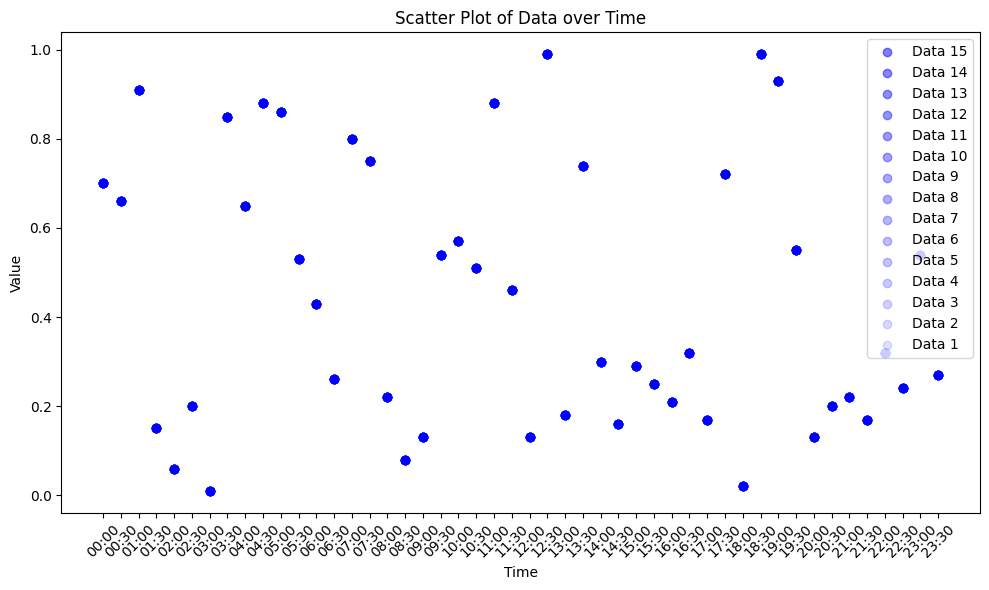

In [28]:
import matplotlib.pyplot as plt
data = []
# 데이터
for i in range(len(checkpoint)):
    data.append(checkpoint[i][0][:])

# 시각화
plt.figure(figsize=(10, 6))

# 데이터 리스트를 반대로 순회하며 시각화
for i, d in enumerate(reversed(data)):
    # x축은 00:00부터 23:30까지 30분 간격
    x = [f"{hour:02d}:{minute:02d}" for hour in range(0, 24) for minute in range(0, 60, 30)]
    y = d
    color = np.array([0, 0, 1, 0.5 - 0.4*i/len(data)])
    plt.scatter(x, y, label=f"Data {len(data)-i}",color=[color])  # 나중에 입력된 리스트일수록 alpha 값 증가0.5 - 0.4*i/len(data)

plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Scatter Plot of Data over Time')
plt.legend()
plt.tight_layout()
plt.show()

# 2. Create a Deep Learning Model with Keras

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
states = envA.observation_space.shape
actions = envA.action_space.n

In [ ]:
actions

100

In [ ]:
def build_model(states, actions):
    model = Sequential()
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
del model

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24)                48        
                                                                 
 dense_7 (Dense)             (None, 24)                600       
                                                                 
 dense_8 (Dense)             (None, 100)               2500      
                                                                 
Total params: 3,148
Trainable params: 3,148
Non-trainable params: 0
_________________________________________________________________


# 3. Build Agent with Keras-RL

In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [ ]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(envA, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 38:47 - reward: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.10/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)


   26/10000 [..............................] - ETA: 10:06 - reward: -0.7143

/usr/local/lib/python3.10/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 11 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.10/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.10/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 13 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.10/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 14 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.10/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 15 + 1) instead
  batch

   46/10000 [..............................] - ETA: 6:27 - reward: -5.4280

/usr/local/lib/python3.10/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 29 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.10/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 30 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.10/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 31 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)


 3547/10000 [=========>....................] - ETA: 1:10 - reward: -9.3698done, took 39.090 seconds


In [ ]:
scores = dqn.test(env, nb_episodes=100, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...
Episode 1: reward: -56.000, steps: 60
Episode 2: reward: -60.000, steps: 60
Episode 3: reward: -50.000, steps: 60
Episode 4: reward: -60.000, steps: 60
Episode 5: reward: -56.000, steps: 60
Episode 6: reward: -52.000, steps: 60
Episode 7: reward: -60.000, steps: 60
Episode 8: reward: -50.000, steps: 60
Episode 9: reward: -52.000, steps: 60
Episode 10: reward: -56.000, steps: 60
Episode 11: reward: -60.000, steps: 60
Episode 12: reward: -60.000, steps: 60
Episode 13: reward: -52.000, steps: 60
Episode 14: reward: -52.000, steps: 60
Episode 15: reward: -58.000, steps: 60
Episode 16: reward: -50.000, steps: 60
Episode 17: reward: -54.000, steps: 60
Episode 18: reward: -58.000, steps: 60
Episode 19: reward: -60.000, steps: 60
Episode 20: reward: -56.000, steps: 60
Episode 21: reward: -56.000, steps: 60
Episode 22: reward: -52.000, steps: 60
Episode 23: reward: -60.000, steps: 60
Episode 24: reward: -56.000, steps: 60
Episode 25: reward: -58.000, steps: 60
Episo

In [ ]:
_ = dqn.test(env, nb_episodes=15, visualize=True)

Testing for 15 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200
Episode 11: reward: 200.000, steps: 200
Episode 12: reward: 200.000, steps: 200
Episode 13: reward: 200.000, steps: 200
Episode 14: reward: 200.000, steps: 200
Episode 15: reward: 200.000, steps: 200


# 4. Reloading Agent from Memory

In [ ]:
dqn.save_weights('dqn_weights.h5f', overwrite=True)

In [ ]:
del model
del dqn
del env

In [ ]:
env = gym.make('CartPole-v0')
actions = env.action_space.n
states = env.observation_space.shape[0]
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
dqn.load_weights('dqn_weights.h5f')

In [ ]:
_ = dqn.test(env, nb_episodes=5, visualize=True)

Testing for 5 episodes ...
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
